In [28]:
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D,
    GlobalMaxPooling1D
)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Persiapan Dataset

In [4]:
# Load dataset
df = pd.read_csv("genshin_reviews.csv")

# Periksa 5 baris pertama untuk memahami struktur dataset
df.head()

,userName,score,content,at
0,Akshay Kumar,5,best game ever but please set one main charact...,2025-04-12 13:45:52
1,Keiko,1,"bro everything is fan service, all female like...",2025-04-12 12:55:23
2,Jocelyn Ragas,5,nicre 10 10,2025-04-09 13:15:20
3,Liza Jortmenadze,2,the game is really good but there's a lot of -...,2025-04-09 13:06:10
4,omo omo90,1,"i played it before, it sucks. i didnt find the...",2025-04-09 13:03:51


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  55000 non-null  object
 1   score     55000 non-null  int64 
 2   content   54995 non-null  object
 3   at        55000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB



Dataset ini berisi **55.000 ulasan pengguna** terhadap game Genshin Impact di  Playstore. Tujuan utama dari dataset ini adalah untuk menganalisis sentimen pengguna terhadap game berdasarkan ulasan teks (*content*) dan skor (*score*) yang sudah ada.

# Preprocessing dan Cleaning

In [6]:
 #menghapus baris yang memiliki nilai yang hilang (NaN) dari data
df = df.dropna()
# Menghapus baris duplikat dari Data
df = df.drop_duplicates()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54995 entries, 0 to 54999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  54995 non-null  object
 1   score     54995 non-null  int64 
 2   content   54995 non-null  object
 3   at        54995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.1+ MB


In [7]:
df['at'] = pd.to_datetime(df['at']).dt.date

df.head()

,userName,score,content,at
0,Akshay Kumar,5,best game ever but please set one main charact...,2025-04-12
1,Keiko,1,"bro everything is fan service, all female like...",2025-04-12
2,Jocelyn Ragas,5,nicre 10 10,2025-04-09
3,Liza Jortmenadze,2,the game is really good but there's a lot of -...,2025-04-09
4,omo omo90,1,"i played it before, it sucks. i didnt find the...",2025-04-09


In [8]:
df.shape

(54995, 4)

In [9]:
def filter_latest_reviews(df):
    # Standarisasi userName agar seragam (opsional tapi disarankan)
    df['userName'] = df['userName'].str.strip().str.lower()

    # Hitung jumlah review per user
    review_counts = df['userName'].value_counts()
    repeated_users = review_counts[review_counts > 1].index

    print(f"Jumlah pengguna dengan lebih dari satu review: {len(repeated_users)}")

    # Tampilkan contoh data user dengan review ganda
    if not repeated_users.empty:
        print("\nContoh pengguna dengan review lebih dari satu (sebelum dihapus):")
        display(df[df['userName'].isin(repeated_users)].head())

    # Simpan ukuran data sebelum penghapusan
    original_rows = df.shape[0]

    # Urutkan berdasarkan tanggal terbaru, simpan hanya review terbaru dari tiap user
    df_sorted = df.sort_values('at', ascending=False)
    df_cleaned = df_sorted.drop_duplicates(subset='userName', keep='first')

    # Hitung selisih jumlah baris
    new_rows = df_cleaned.shape[0]
    removed_rows = original_rows - new_rows

    print(f"\nJumlah baris sebelum: {original_rows}")
    print(f"Jumlah baris sesudah: {new_rows}")
    print(f"Jumlah baris yang dihapus: {removed_rows}")

    return df_cleaned

df = filter_latest_reviews(df)


Jumlah pengguna dengan lebih dari satu review: 1334

Contoh pengguna dengan review lebih dari satu (sebelum dihapus):


,userName,score,content,at
0,akshay kumar,5,best game ever but please set one main charact...,2025-04-12
16,hello there,1,Change paimon VA.,2025-04-09
41,abhishek kundaikar,5,"GAME💫, GRAPHICS🗿📈, OPTIMIZATION 💅📈, MUSIC❤️📈, ...",2025-04-09
46,dani,5,Always wanted to play an open world roleplayin...,2025-04-09
72,em,5,Great game. I love how w3 can explore all the ...,2025-04-09



Jumlah baris sebelum: 54995
Jumlah baris sesudah: 52690
Jumlah baris yang dihapus: 2305


In [10]:
df.content.duplicated().sum()
df.userName.duplicated().sum()

np.int64(0)

In [11]:

# Ambil daftar kata bahasa Inggris
english_vocab = set(words.words())

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Ubah menjadi huruf kecil semua
        text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Hapus URL
        text = re.sub(r'@\w+', '', text)  # Hapus mention
        text = re.sub(r'#\w+', '', text)  # Hapus hashtag
        text = re.sub(r'\d+', '', text)  # Hapus angka
        text = re.sub(r'[^\w\s]', '', text)  # Hapus karakter khusus dan emoji
        text = re.sub(r'\s+', ' ', text).strip()  # Hilangkan spasi berlebih
    return text

def detect_english(text):
    if not isinstance(text, str) or not text.strip():
        return False

    tokens = text.split()
    if not tokens:
        return False

    match_count = sum(1 for word in tokens if word in english_vocab)
    ratio = match_count / len(tokens)
    return ratio >= 0.6  # Ambang batas kelayakan sebagai bahasa Inggris

# Bersihkan teks di kolom 'content'
df['cleaned_content'] = df['content'].apply(preprocess_text)

df = df[df['cleaned_content'].apply(detect_english)]

df = df[df['cleaned_content'].str.strip() != '']

# Show sample after processing
df[['content', 'cleaned_content']]

,content,cleaned_content
0,best game ever but please set one main charact...,best game ever but please set one main charact...
1,"bro everything is fan service, all female like...",bro everything is fan service all female like ...
56,fun game,fun game
65,my luck was insane in pulling and life changin...,my luck was insane in pulling and life changin...
63,here's a guaranteed 2 star rating matching the...,heres a guaranteed star rating matching the gu...
...,...,...
54971,This one of the best games I ever played,this one of the best games i ever played
54972,"As I said in my old review, this game is decen...",as i said in my old review this game is decent...
54974,The game is beautiful and i love playing it BU...,the game is beautiful and i love playing it bu...
54975,"Good game, but totally messed up mihoyo accoun...",good game but totally messed up mihoyo account...


In [12]:
# Kamus slang dan padanannya dalam bentuk formal
informal_words = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "got to",
    "lemme": "let me",
    "gimme": "give me",
    "aint": "is not",
    "im": "I am",
    "iam": "I am",
    "idk": "I don't know",
    "btw": "by the way",
    "lol": "laughing out loud",
    "brb": "be right back",
    "omg": "oh my god",
    "thx": "thanks",
    "ty": "thank you",
    "lmk": "let me know",
    "smh": "shaking my head",
    "fyi": "for your information",
    "tbh": "to be honest",
    "dm": "direct message",
    "dis": "this",
    "plz": "please",
    "gam": "game",
    "qol": "quality of life",
    "devs": "developers",
    "gg": "good game",
    "op": "overpowered",
    "meta": "most effective tactics available",
    "buff": "improve",
    "nerf": "weaken",
    "grindy": "requiring a lot of repetitive effort",
    "gacha": "lottery-based system",
    "reroll": "restart to get better result",
    "resin": "in-game energy",
    "f2p": "free to play",
    "p2w": "pay to win",
    "waifu": "favorite female character",
    "husbando": "favorite male character",
    "afk": "away from keyboard",
    "asf": "as hell"  # biasanya digunakan sebagai intensifier
}

# Buat pola regex dari daftar kata slang
slang_regex = re.compile(r'\b(' + '|'.join(re.escape(word) for word in informal_words) + r')\b', re.IGNORECASE)

# Fungsi untuk mengganti slang dengan bentuk formal
def normalize_slang(text):
    if isinstance(text, str):
        return slang_regex.sub(lambda x: informal_words[x.group(0).lower()], text)
    return text

# Terapkan ke kolom yang sudah dibersihkan
df['cleaned_content'] = df['cleaned_content'].apply(normalize_slang)

df[['content', 'cleaned_content']]


,content,cleaned_content
0,best game ever but please set one main charact...,best game ever but please set one main charact...
1,"bro everything is fan service, all female like...",bro everything is fan service all female like ...
56,fun game,fun game
65,my luck was insane in pulling and life changin...,my luck was insane in pulling and life changin...
63,here's a guaranteed 2 star rating matching the...,heres a guaranteed star rating matching the gu...
...,...,...
54971,This one of the best games I ever played,this one of the best games i ever played
54972,"As I said in my old review, this game is decen...",as i said in my old review this game is decent...
54974,The game is beautiful and i love playing it BU...,the game is beautiful and i love playing it bu...
54975,"Good game, but totally messed up mihoyo accoun...",good game but totally messed up mihoyo account...


In [20]:
# Ambil stopwords bahasa Inggris dari NLTK
base_stopwords = set(stopwords.words('english'))

# Tambahkan stopwords khusus yang sering muncul di review game
domain_stopwords = {
    "game", "mobile", "play", "player", "gaming", "genshin","impact", "like",
    "cant", "dont", "doesnt"
}

# Gabungkan semua stopwords
all_stopwords = frozenset(base_stopwords | domain_stopwords)

# Inisialisasi lemmatizer dan regex untuk huruf alfabet saja
lemmatizer = WordNetLemmatizer()
alphabet_only = re.compile(r"^[a-zA-Z]+$")

# Fungsi utama preprocessing teks
def process_review_text(text):
    if not isinstance(text, str) or not text.strip():
        return None

    # Tokenisasi dan ubah ke huruf kecil
    tokens = word_tokenize(text.lower())

    # Proses token: buang stopwords, filter huruf, dan lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in all_stopwords and alphabet_only.match(word)
    ]

    return " ".join(clean_tokens) if clean_tokens else None

df['cleaned_content'] = df['cleaned_content'].astype(str).apply(process_review_text)
df.dropna(subset=['cleaned_content'], inplace=True)



# Show sample after processing
df[['content', 'cleaned_content']]

,content,cleaned_content
0,best game ever but please set one main charact...,best ever please set one main character many c...
1,"bro everything is fan service, all female like...",bro everything fan service female new male sta...
56,fun game,fun
65,my luck was insane in pulling and life changin...,luck insane pulling life changing
63,here's a guaranteed 2 star rating matching the...,guaranteed star rating matching guaranteed rol...
...,...,...
54971,This one of the best games I ever played,one best ever played
54972,"As I said in my old review, this game is decen...",said old review decent worth time google stop ...
54974,The game is beautiful and i love playing it BU...,beautiful love playing need way much storage s...
54975,"Good game, but totally messed up mihoyo accoun...",good totally messed mihoyo account policy


# Pelabelan Data

In [14]:
# Buat instance dari analyzer VADER
vader_analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk klasifikasi sentimen berdasarkan skor compound
def classify_sentiment(text):
    if not isinstance(text, str) or not text.strip():
        return "Neutral"  # Default untuk input tidak valid atau kosong

    compound_score = vader_analyzer.polarity_scores(text).get('compound', 0)

    if compound_score > 0.05:
        return "Positive"
    elif compound_score < -0.05:
        return "Negative"
    else:
        return "Neutral"

# Terapkan ke kolom content_cleaned
df['sentiment'] = df['cleaned_content'].apply(classify_sentiment)

# Show sample results
df[['cleaned_content', 'sentiment']].sample(10)

,cleaned_content,sentiment
33318,love graphic adventuring n exploring also down...,Positive
7875,give star havent try,Neutral
8502,soo app eat storage enough storage well enjoy,Positive
4051,overall experience good impressive fun mixing ...,Positive
20626,love much,Positive
2252,love,Positive
43189,company going take various latin african polyn...,Negative
571,used enjoy lot ever since came feel story exec...,Negative
21808,super sigma,Positive
16639,ive playing awhile nowstarted eulas first bann...,Positive


# Visualisasi Insight

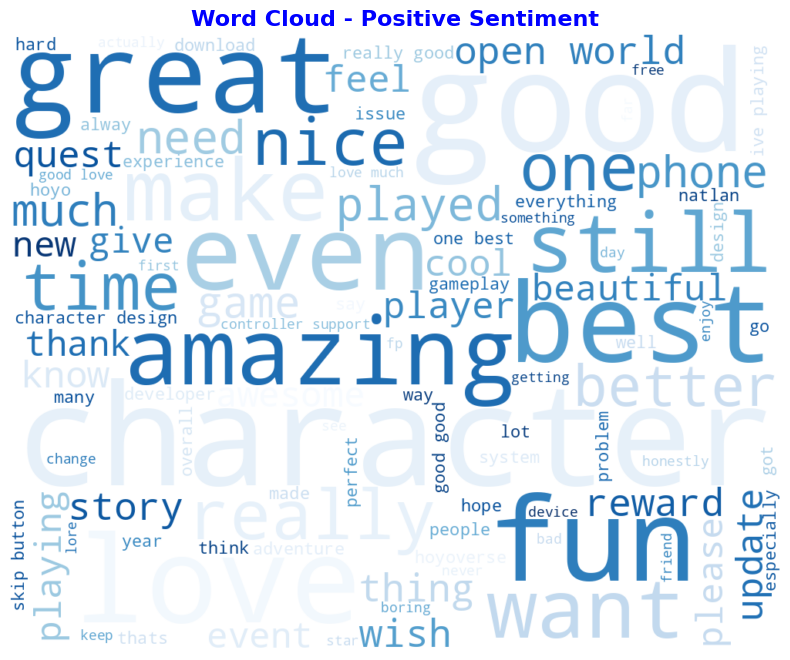

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan teks untuk sentimen positif
positive_text = " ".join(df[df['sentiment'] == 'Positive']['cleaned_content'].dropna())

# Buat dan tampilkan WordCloud untuk sentimen positif
wordcloud_positive = WordCloud(
    width=1000,
    height=800,
    background_color='white',
    max_words=100,
    colormap='Blues',
    contour_color='black',
    contour_width=1.5,
    random_state=42
).generate(positive_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment", fontsize=16, fontweight='bold', color='blue')
plt.show()


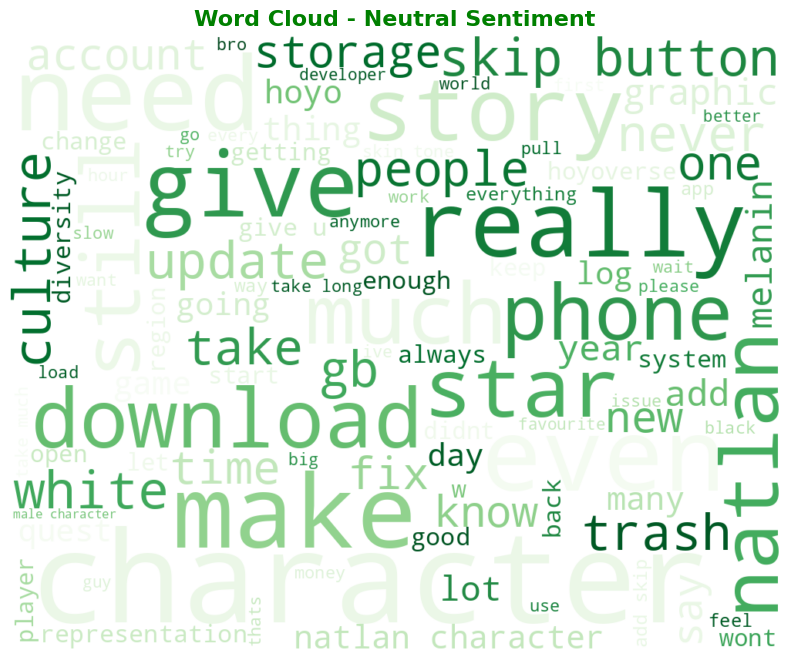

In [16]:
# Gabungkan teks untuk sentimen netral
neutral_text = " ".join(df[df['sentiment'] == 'Neutral']['cleaned_content'].dropna())

# Buat dan tampilkan WordCloud untuk sentimen netral
wordcloud_neutral = WordCloud(
    width=1000,
    height=800,
    background_color='white',
    max_words=100,
    colormap='Greens',
    contour_color='black',
    contour_width=1.5,
    random_state=42
).generate(neutral_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Neutral Sentiment", fontsize=16, fontweight='bold', color='green')
plt.show()


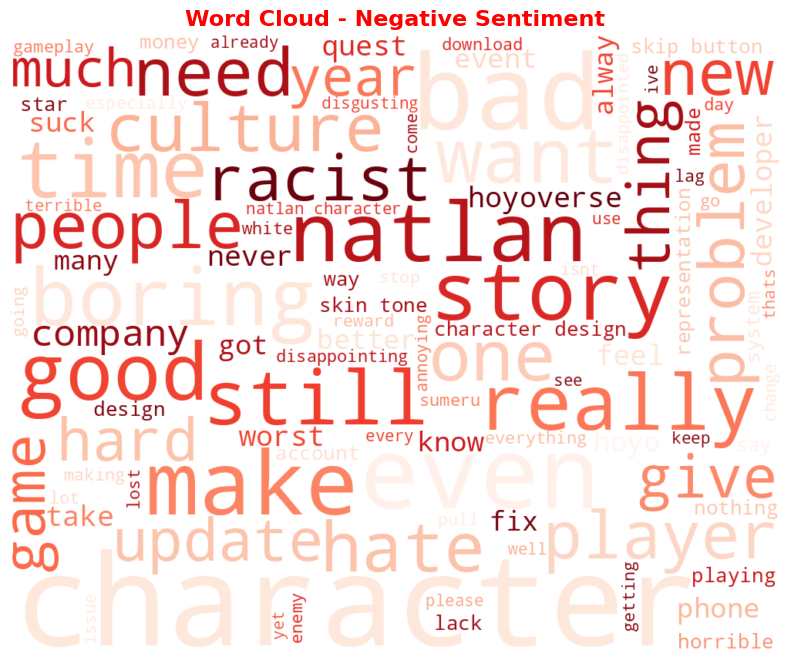

In [17]:
# Gabungkan teks untuk sentimen negatif
negative_text = " ".join(df[df['sentiment'] == 'Negative']['cleaned_content'].dropna())

# Buat dan tampilkan WordCloud untuk sentimen negatif
wordcloud_negative = WordCloud(
    width=1000,
    height=800,
    background_color='white',
    max_words=100,
    colormap='Reds',
    contour_color='black',
    contour_width=1.5,
    random_state=42
).generate(negative_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment", fontsize=16, fontweight='bold', color='red')
plt.show()


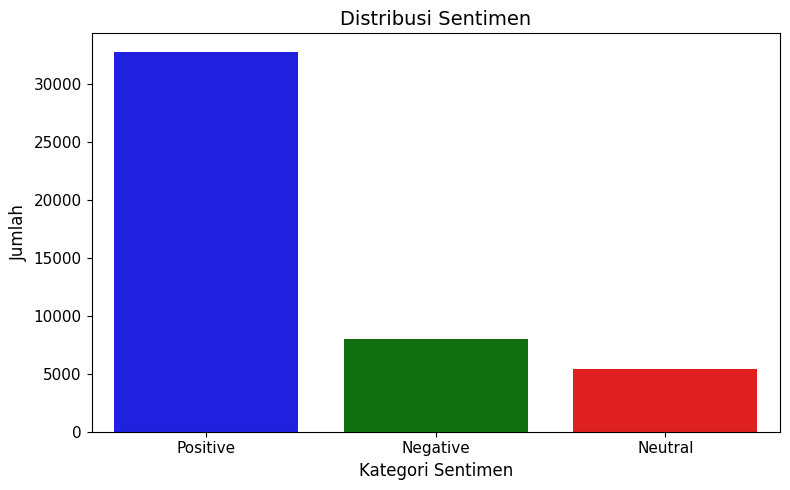

In [18]:
# Menghitung jumlah masing-masing kategori sentimen
jumlah_sentimen = df['sentiment'].value_counts()

# Membuat figure untuk visualisasi
plt.figure(figsize=(8, 5))

# Menampilkan bar chart untuk distribusi sentimen
sns.barplot(
    x=jumlah_sentimen.index,
    y=jumlah_sentimen.values,
    hue=jumlah_sentimen.index,
    palette=['blue', 'green', 'red'],
    dodge=False,
    legend=False
)

# Menyesuaikan tampilan label dan judul grafik
plt.xlabel("Kategori Sentimen", fontsize=12)
plt.ylabel("Jumlah", fontsize=12)
plt.title("Distribusi Sentimen", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Menampilkan plot
plt.tight_layout()
plt.show()


In [19]:
df.head()

,userName,score,content,at,cleaned_content,sentiment
0,akshay kumar,5,best game ever but please set one main charact...,2025-04-12,best ever please set one main character many c...,Positive
1,keiko,1,"bro everything is fan service, all female like...",2025-04-12,bro everything fan service female new male sta...,Positive
56,aurelio salazar,4,fun game,2025-04-09,fun,Positive
65,zyril ursal,5,my luck was insane in pulling and life changin...,2025-04-09,luck insane pulling life changing,Positive
63,jhemar nueva,2,here's a guaranteed 2 star rating matching the...,2025-04-09,here guaranteed star rating matching guarantee...,Neutral


## Insight  

Mayoritas ulasan mengenai Genshin Impact cenderung menunjukkan sentimen positif, yang mengindikasikan bahwa sebagian besar pemain merasa puas dengan pengalaman yang mereka dapatkan dari permainan ini. Ada pula sejumlah ulasan dengan sentimen netral, yang kemungkinan berasal dari pemain yang tidak memiliki pendapat yang kuat, baik itu positif maupun negatif. Sementara itu, ulasan dengan sentimen negatif terlihat relatif sedikit jumlahnya, yang menunjukkan bahwa keluhan atau ketidakpuasan terhadap permainan ini tidak begitu dominan dalam dataset yang dianalisis. Secara keseluruhan, hal ini menunjukkan bahwa secara umum, Genshin Impact mendapatkan sambutan yang cukup baik dari para pemainnya.










# Modelling

# Logistic Regression, SVM dan Random Forest

## Ekstraksi Fitur

In [22]:
# 1. Bersihkan data & pilih kolom yang akan dipakai
df_clean = df[['cleaned_content', 'sentiment']].dropna().drop_duplicates().reset_index(drop=True)

# 2. Ekstraksi fitur TF-IDF (hanya setelah df sudah bersih)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_clean['cleaned_content'].astype(str))
y = df_clean['sentiment']


# 3. Split data untuk model klasik
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)


In [29]:
# Membuat dan melatih model Logistic Regression
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_tfidf, y_train)

# Prediksi pada data train dan test
y_pred_train_lr = logistic_regression.predict(X_train_tfidf)
y_pred_test_lr = logistic_regression.predict(X_test_tfidf)

# Evaluasi akurasi
accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9409121230207492
Logistic Regression - accuracy_test: 0.9031034966999018


In [31]:

# Membuat dan melatih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Prediksi pada data train dan test
y_pred_train_rf = rf_model.predict(X_train_tfidf)
y_pred_test_rf = rf_model.predict(X_test_tfidf)

# Evaluasi akurasi
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9990871748060246
Random Forest - accuracy_test: 0.8632214576604409


In [30]:

# Membuat dan melatih model SVM
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)

# Prediksi pada data train dan test
y_pred_train_svm = svm_model.predict(X_train_tfidf)
y_pred_test_svm = svm_model.predict(X_test_tfidf)

# Evaluasi akurasi
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

# Menampilkan akurasi
print('SVM (RBF Kernel) - accuracy_train:', accuracy_train_svm)
print('SVM (RBF Kernel) - accuracy_test:', accuracy_test_svm)

SVM (RBF Kernel) - accuracy_train: 0.9827265386370818
SVM (RBF Kernel) - accuracy_test: 0.9002949024013481


## testing model

In [32]:
# Fungsi untuk klasifikasi sentimen
def classify_sentiment_ml(input_text, model, vectorizer):
    # Transform input text dengan TF-IDF vectorizer
    transformed_text = vectorizer.transform([input_text])

    # Prediksi sentimen
    predicted_label = model.predict(transformed_text)[0]

    # Mapping label prediksi ke nama sentimen
    sentiment_labels = {
        "Positive": "Positive",
        "Neutral": "Neutral",
        "Negative": "Negative"
    }

    return predicted_label, sentiment_labels.get(predicted_label, "Unknown")

# Contoh input kalimat
sample_inputs = [
    "I really enjoyed the storyline and visuals, great experience!",     # Positive
    "Nothing special about this app, it's just okay.",                  # Neutral
    "The app crashes too often and is very frustrating to use.",        # Negative
    "Nice effort, but some features didn’t work as expected.",          # Neutral
    "Absolutely loved it! One of the best apps I've used this year.",   # Positive
]

# Prediksi dengan Logistic Regression
print("=== Logistic Regression Predictions ===")
for sentence in sample_inputs:
    score, label = classify_sentiment_ml(sentence, logistic_regression, vectorizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {label} (Label: {score})\n")

# Prediksi dengan SVM
print("=== SVM Predictions ===")
for sentence in sample_inputs:
    score, label = classify_sentiment_ml(sentence, svm_model, vectorizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {label} (Label: {score})\n")

# Prediksi dengan Random Forest
print("=== Random Forest Predictions ===")
for sentence in sample_inputs:
    score, label = classify_sentiment_ml(sentence, rf_model, vectorizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {label} (Label: {score})\n")


=== Logistic Regression Predictions ===
Text: I really enjoyed the storyline and visuals, great experience!
Predicted Sentiment: Positive (Label: Positive)

Text: Nothing special about this app, it's just okay.
Predicted Sentiment: Positive (Label: Positive)

Text: The app crashes too often and is very frustrating to use.
Predicted Sentiment: Negative (Label: Negative)

Text: Nice effort, but some features didn’t work as expected.
Predicted Sentiment: Positive (Label: Positive)

Text: Absolutely loved it! One of the best apps I've used this year.
Predicted Sentiment: Positive (Label: Positive)

=== SVM Predictions ===
Text: I really enjoyed the storyline and visuals, great experience!
Predicted Sentiment: Positive (Label: Positive)

Text: Nothing special about this app, it's just okay.
Predicted Sentiment: Positive (Label: Positive)

Text: The app crashes too often and is very frustrating to use.
Predicted Sentiment: Negative (Label: Negative)

Text: Nice effort, but some features didn

#LSTM

In [37]:
df = df[['cleaned_content', 'sentiment']].dropna().copy()

# Label Encoding
target_encoder = LabelEncoder()
df['sentiment'] = target_encoder.fit_transform(df['sentiment'])

# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_content'])

X = tokenizer.texts_to_sequences(df['cleaned_content'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

y = np.array(df['sentiment'])

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def create_optimized_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Dropout(0.4),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Create new model
model = create_optimized_lstm_model(vocab_size=max_words, embedding_dim=100, input_length=max_len)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 374s 613ms/step - accuracy: 0.7259 - loss: 0.9837 - val_accuracy: 0.9003 - val_loss: 0.3590 - learning_rate: 5.0000e-04
Epoch 2/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 377s 606ms/step - accuracy: 0.8971 - loss: 0.3561 - val_accuracy: 0.9244 - val_loss: 0.2503 - learning_rate: 5.0000e-04
Epoch 3/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 386s 613ms/step - accuracy: 0.9322 - loss: 0.2458 - val_accuracy: 0.9330 - val_loss: 0.2183 - learning_rate: 5.0000e-04
Epoch 4/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 381s 611ms/step - accuracy: 0.9506 - loss: 0.1967 - val_accuracy: 0.9350 - val_loss: 0.2136 - learning_rate: 5.0000e-04
Epoch 5/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 382s 612ms/step - accuracy: 0.9570 - loss: 0.1721 - val_accuracy: 0.9355 - val_loss: 0.2213 - learning_rate: 5.0000e-04
Epoch 6/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 381s 610ms/step - accuracy: 0.9645 - loss: 0.1468 - val_accuracy: 0.9371 - val_loss: 0.2245 - learning_rate: 5.0000e-04
Epoch 7/20
578/578 ━━━━━━━━━━━━━━━━━━━━ 

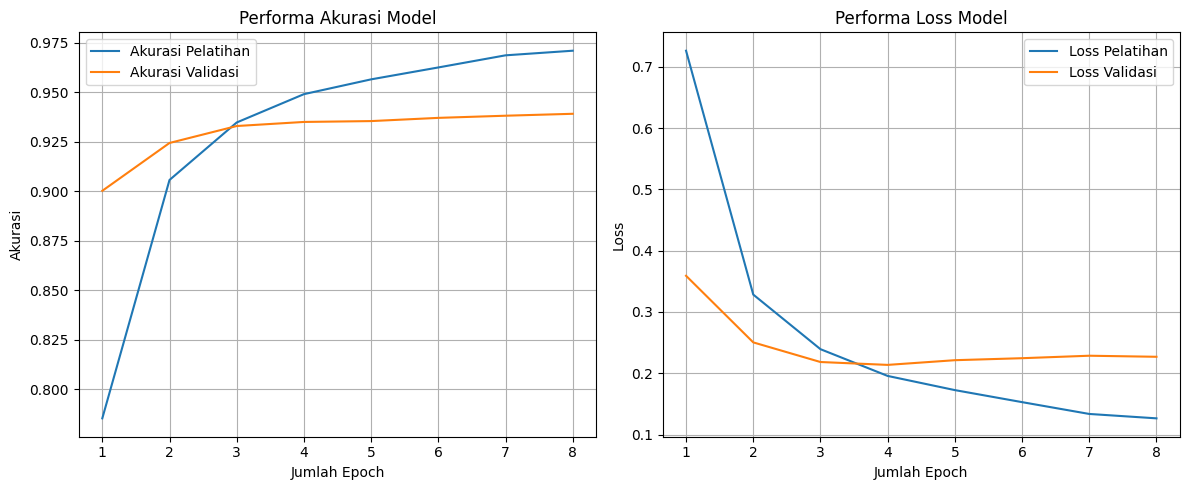

In [38]:
# Mengambil data akurasi dan loss dari hasil pelatihan model
accuracy_training = history.history['accuracy']
accuracy_validation = history.history['val_accuracy']
loss_training = history.history['loss']
loss_validation = history.history['val_loss']
epoch_range = range(1, len(accuracy_training) + 1)

# Visualisasi Akurasi Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, accuracy_training, label='Akurasi Pelatihan')
plt.plot(epoch_range, accuracy_validation, label='Akurasi Validasi')
plt.xlabel('Jumlah Epoch')
plt.ylabel('Akurasi')
plt.title('Performa Akurasi Model')
plt.legend()
plt.grid(True)

# Visualisasi Loss Model
plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss_training, label='Loss Pelatihan')
plt.plot(epoch_range, loss_validation, label='Loss Validasi')
plt.xlabel('Jumlah Epoch')
plt.ylabel('Loss')
plt.title('Performa Loss Model')
plt.legend()
plt.grid(True)

# Menampilkan hasil plot
plt.tight_layout()
plt.show()


In [39]:
# Prediksi pada data validasi
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating matrix evaluation
accuracy = accuracy * 100
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

print(results)

289/289 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step
{'accuracy': 93.50298047065735, 'precision': 0.9347249371517535, 'recall': 0.9350297780184083, 'f1': 0.9346260533315963}


## testing performa model

In [40]:

def classify_sentiment(input_text, model, tokenizer, max_length=100):
    # Convert input text into token sequences
    tokenized_text = tokenizer.texts_to_sequences([input_text])

    # Pad sequences to the same length
    padded_text = pad_sequences(tokenized_text, maxlen=max_length, padding='post', truncating='post')

    # Run prediction
    prediction_result = model.predict(padded_text)
    predicted_label = np.argmax(prediction_result)

    # Sentiment label mapping
    sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return predicted_label, sentiment_labels[predicted_label]

# New sample texts
sample_inputs = [
    "I really enjoyed the storyline and visuals, great experience!",     # Positive
    "Nothing special about this app, it's just okay.",                  # Neutral
    "The app crashes too often and is very frustrating to use.",        # Negative
    "Nice effort, but some features didn’t work as expected.",          # Neutral
    "Absolutely loved it! One of the best apps I've used this year.",   # Positive
]

# Predict sentiment for each text
for sentence in sample_inputs:
    score, label = classify_sentiment(sentence, model, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {label} (Score: {score})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Text: I really enjoyed the storyline and visuals, great experience!
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Text: Nothing special about this app, it's just okay.
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Text: The app crashes too often and is very frustrating to use.
Predicted Sentiment: Negative (Score: 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Text: Nice effort, but some features didn’t work as expected.
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Text: Absolutely loved it! One of the best apps I've used this year.
Predicted Sentiment: Positive (Score: 2)

